In [ ]:
!pip install scapy

In [ ]:
import ipywidgets as widgets
from IPython.display import display, clear_output
!pip install matplotlib seaborn pandas

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import scapy.all as scapy
from collections import Counter
from google.colab import files
import datetime

In [ ]:
from google.colab import files
from collections import Counter

uploaded = files.upload()


pcap_file = next(iter(uploaded))

# Read the pcap file using Scapy
packets = scapy.rdpcap(pcap_file)

print(f"Loaded {len(packets)} packets from {pcap_file}")


Saving icmp-flood-0.pcap to icmp-flood-0 (2).pcap
Loaded 4020 packets from icmp-flood-0 (2).pcap


In [ ]:
import ipywidgets as widgets
from IPython.display import display, clear_output
threshold_slider = widgets.IntSlider(
    value=50, min=10, max=200, step=5,
    description='ICMP Threshold:',
    continuous_update=False  # updates only on slider release
) # Added closing parenthesis here

# Output area to show results
output = widgets.Output()


def on_threshold_change(change):
    # Clear previous output and run detection again with new threshold
    with output:
        clear_output()
        new_threshold = change['new']
        print(f"Running detection with threshold: {new_threshold}")
        detect_icmp_echo_flood(packets, threshold=new_threshold)

# Link the slider value changes to the handler function
threshold_slider.observe(on_threshold_change, names='value')

# Display slider and output area
display(threshold_slider, output)

# Run detection initially with default threshold
with output:
    detect_icmp_echo_flood(packets, threshold=threshold_slider.value)

IntSlider(value=50, continuous_update=False, description='ICMP Threshold:', max=200, min=10, step=5)

Output()

In [ ]:




#  Defining a function to detect ICMP Echo Flood attack
def detect_icmp_echo_flood(packets, threshold=50):
    """
    Detect possible ICMP Echo (ping) flood attack based on number of ICMP Echo Request packets per source IP.
    """
    icmp_echo_requests = [pkt for pkt in packets if pkt.haslayer(scapy.ICMP) and pkt[scapy.ICMP].type == 8]
    icmp_counts = Counter(pkt[scapy.IP].src for pkt in icmp_echo_requests)

    attackers = [ip for ip, count in icmp_counts.items() if count > threshold]

    if attackers:
        print("Possible ICMP Echo (Ping) Flood Attack detected from IP(s):")
        for ip in attackers:
            print(f"  Source IP: {ip}, ICMP Echo Requests: {icmp_counts[ip]}")
    else:
        print("No ICMP Echo flood attack detected.")

#  Run the detection function and display output
detect_icmp_echo_flood(packets)

Possible ICMP Echo (Ping) Flood Attack detected from IP(s):
  Source IP: 192.168.80.2, ICMP Echo Requests: 2000


Summary Statistics:
Total ICMP Echo Requests: 2000
Unique Source IPs: 1
Top 5 Source IPs by Request Count:
  192.168.80.2: 2000 packets


/tmp/ipython-input-2799647770.py:44: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  pps = df.resample('1S').size()


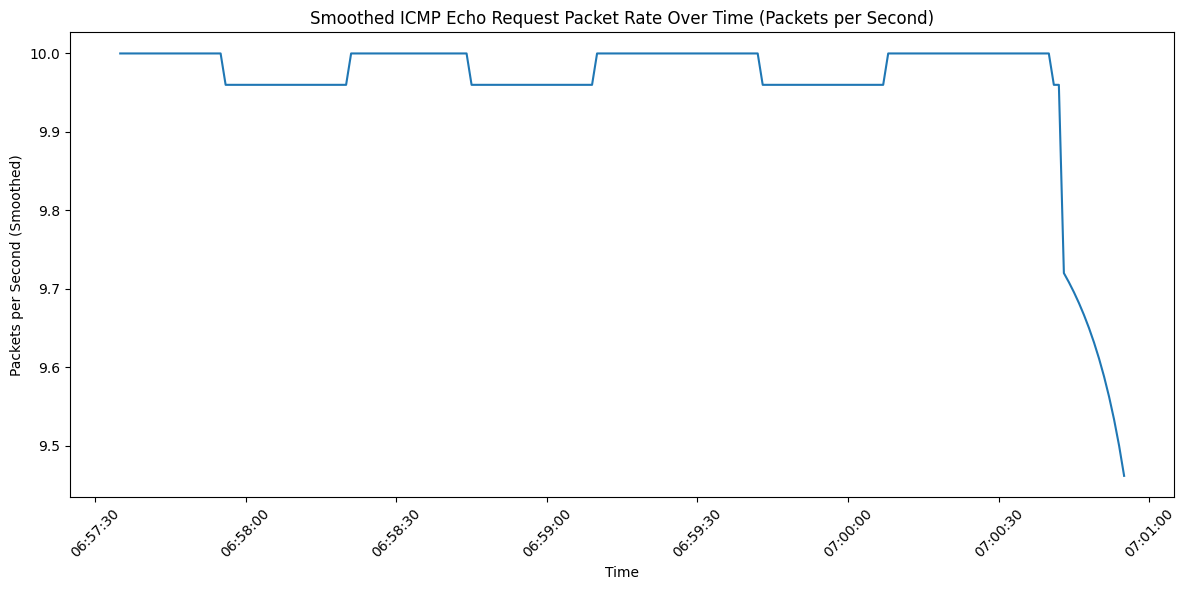

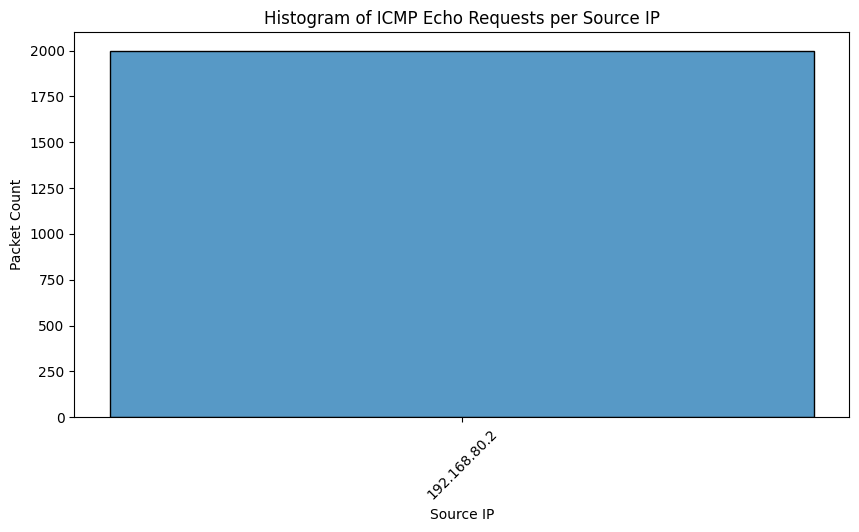

In [ ]:
# Step 3: Analysis function to get summary and data for visualization
def icmp_flood_analysis(packets):
    icmp_echo_requests = [pkt for pkt in packets if pkt.haslayer(scapy.ICMP) and pkt[scapy.ICMP].type == 8]
    # Count per source IP
    ip_counts = Counter(pkt[scapy.IP].src for pkt in icmp_echo_requests)
    # Build DataFrame for analysis
    data = []
    for pkt in icmp_echo_requests:
        timestamp = datetime.datetime.fromtimestamp(float(pkt.time))
        src_ip = pkt[scapy.IP].src
        data.append({"timestamp": timestamp, "src_ip": src_ip})
    df = pd.DataFrame(data)
    if df.empty:
        print("No ICMP Echo Requests found in the pcap.")
        return None, None
    # Summary statistics
    summary = {
        "total_icmp_echo_requests": len(icmp_echo_requests),
        "unique_source_ips": len(ip_counts),
        "top_source_ips": ip_counts.most_common(5)
    }
    return summary, df

summary, df = icmp_flood_analysis(packets)

# Step 4: Print summary report
if summary:
    print("Summary Statistics:")
    print(f"Total ICMP Echo Requests: {summary['total_icmp_echo_requests']}")
    print(f"Unique Source IPs: {summary['unique_source_ips']}")
    print("Top 5 Source IPs by Request Count:")
    for ip, count in summary['top_source_ips']:
        print(f"  {ip}: {count} packets")

# Step 5: Visualization
if df is not None and not df.empty:
    # Convert timestamps to datetime objects and set as index
    df = df.set_index('timestamp')

    # Sort index to ensure chronological order
    df = df.sort_index()

    # Resample over 1-second intervals counting packets per second (pps)
    pps = df.resample('1S').size()

    # Fill any gaps with 0 so the line plot is continuous
    pps = pps.fillna(0)

    # Apply rolling average to smooth the line graph (window size = 5 seconds)
    pps_smooth = pps.rolling(window=25, min_periods=2, center=True).mean()

    plt.figure(figsize=(12,6))
    sns.lineplot(data=pps_smooth)
    plt.title("Smoothed ICMP Echo Request Packet Rate Over Time (Packets per Second)")
    plt.xlabel("Time")
    plt.ylabel("Packets per Second (Smoothed)")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # Histogram of packet counts per source IP
    plt.figure(figsize=(10,5))
    sns.histplot(df['src_ip'], bins=len(df['src_ip'].unique()), discrete=True)
    plt.title("Histogram of ICMP Echo Requests per Source IP")
    plt.xlabel("Source IP")
    plt.ylabel("Packet Count")
    plt.xticks(rotation=45)
    plt.show()





In [ ]:
def icmp_flood_analysis_detailed(packets):
    data = []
    for i, pkt in enumerate(packets):
        if pkt.haslayer(scapy.ICMP) and pkt[scapy.ICMP].type == 8:  # ICMP Echo Request
            timestamp = datetime.datetime.fromtimestamp(float(pkt.time))
            src_ip = pkt[scapy.IP].src
            dst_ip = pkt[scapy.IP].dst
            icmp_type = pkt[scapy.ICMP].type
            icmp_code = pkt[scapy.ICMP].code
            pkt_len = len(pkt)
            ttl = pkt[scapy.IP].ttl

            data.append({
                "packet_number": i + 1,
                "timestamp": timestamp,
                "src_ip": src_ip,
                "dst_ip": dst_ip,
                "icmp_type": icmp_type,
                "icmp_code": icmp_code,
                "packet_length": pkt_len,
                "ttl": ttl
            })
    df = pd.DataFrame(data)
    return df

# Use this to generate detailed report DataFrame
df_detailed = icmp_flood_analysis_detailed(packets)

# Save and download the enriched CSV report
csv_filename = "icmp_echo_requests_detailed_report.csv"
df_detailed.to_csv(csv_filename, index=False)
files.download(csv_filename)

# Optional: print first few rows to verify
print(df_detailed.head())

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

   packet_number                  timestamp        src_ip        dst_ip  \
0              1 2021-05-20 06:57:35.036044  192.168.80.2  192.168.80.6   
1              3 2021-05-20 06:57:35.136267  192.168.80.2  192.168.80.6   
2              5 2021-05-20 06:57:35.236427  192.168.80.2  192.168.80.6   
3              7 2021-05-20 06:57:35.336719  192.168.80.2  192.168.80.6   
4              9 2021-05-20 06:57:35.436937  192.168.80.2  192.168.80.6   

   icmp_type  icmp_code  packet_length  ttl  
0          8          0             42   64  
1          8          0             42   64  
2          8          0             42   64  
3          8          0             42   64  
4          8          0             42   64  
